Logs
- [2023/10/17]    
  Splitting train and test sets in the original time series gives us more  
  complicated problem.  In the textbook, the author split the time series on  
  its transformed time series and forecast then transformed back the result.    
  In this way, we only consider to add `TRAIN_LEN` by 1.

# Chapter 10 - Forecasting multiple time series

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import itertools as itertls
import statsmodels.api as sm_api

from tqdm import notebook
from typing import Union

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [12]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


**Function declarations**

In [13]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    # formatter = mdates.DateFormatter("%Y-%b")
    locator = mdates.YearLocator(base=4)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)


In [14]:
def multiple_plot_time_series(df, ax_shape, selected_cols, xlabel_on_cols, 
                              date_col_name, figsize=(6, 6), ylabel_list=None, 
                              use_date_locator=True):
  fig, axes = plt.subplots(nrows=ax_shape[0], ncols=ax_shape[1], 
                            figsize=figsize, sharex=True)

  for (i, ax), col_name in zip(enumerate(axes.flatten()), selected_cols):
    ax.plot(df[date_col_name], df[col_name])
    ax.set_title(col_name)
    ax.grid("on")

    if ylabel_list != None:
      ax.set_ylabel(ylabel_list[i])

    if col_name in xlabel_on_cols:
      for j, label in enumerate(ax.get_xticklabels()):
        label.set_rotation(40)
        label.set_horizontalalignment('right')

    if use_date_locator:
      formatter = mdates.DateFormatter("%Y")
      # formatter = mdates.DateFormatter("%Y-%b")
      locator = mdates.YearLocator(base=5)
      # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
      ax.xaxis.set_major_formatter(formatter)
      ax.xaxis.set_major_locator(locator)

  plt.subplots_adjust(hspace=0.3, wspace=0.2)
  plt.show(fig)

In SARIMAX model, we only examine that the the relationship between target  
variable and exogenous variable are unidirectional (exogeneous is a predictor
of target variable).   
It is possible to have two-way directional influence between time series and
gives us output predictions for both time series simultaneously.  

This bring us to the _vector autoregression_ (VAR) model.  This particular model  
allows us to capture the relationship between multiple time series as they change  
over time.  
That, in turn, allows us to produce forecasts for many time series simultaneously,  
therefore performing multivariate forecasting.

Throughout this week we will use the following two time series: 
real disposable income and real consumption   
which are the same dataset as the previous week 

In [15]:
dir(sm_api.datasets)

['PytestTester',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'anes96',
 'cancer',
 'ccard',
 'check_internet',
 'china_smoking',
 'clear_data_home',
 'co2',
 'committee',
 'copper',
 'cpunish',
 'danish_data',
 'elnino',
 'engel',
 'fair',
 'fertility',
 'get_data_home',
 'get_rdataset',
 'grunfeld',
 'heart',
 'interest_inflation',
 'longley',
 'macrodata',
 'modechoice',
 'nile',
 'randhie',
 'scotland',
 'spector',
 'stackloss',
 'star98',
 'statecrime',
 'strikes',
 'sunspots',
 'test',
 'utils',
 'webuse']

In [16]:
macro_econ_data = sm_api.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Select only `realdpi` and `realcons` 

In [17]:
df_dpi_cons = pd.DataFrame({"year": 
  pd.to_datetime([f"{int(y)}-{int(3*(q-1) + 1):02d}-01" for y, q in zip(
    macro_econ_data['year'],
    macro_econ_data['quarter']
  )]),
  "realdpi": macro_econ_data["realdpi"],
  "realcons": macro_econ_data["realcons"]
})
df_dpi_cons

,year,realdpi,realcons
0,1959-01-01,1886.9,1707.4
1,1959-04-01,1919.7,1733.7
2,1959-07-01,1916.4,1751.8
3,1959-10-01,1931.3,1753.7
4,1960-01-01,1955.5,1770.5
...,...,...,...
198,2008-07-01,9838.3,9267.7
199,2008-10-01,9920.4,9195.3
200,2009-01-01,9926.4,9209.2
201,2009-04-01,10077.5,9189.0


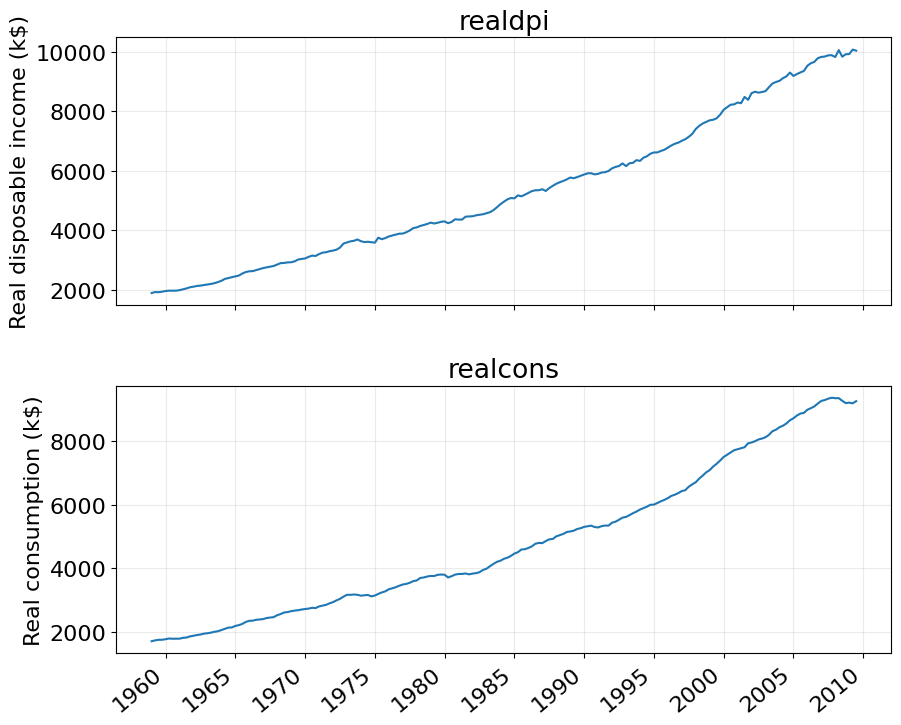

In [19]:
multiple_plot_time_series(df_dpi_cons, [2, 1], ["realdpi", "realcons"], 
                            ["realcons"], "year", figsize=(10, 8), 
                            ylabel_list=["Real disposable income (k$)",
                                        "Real consumption (k$)"])

Real consumption expressess how much money people spend, while real disposable  
income represents how much money is available to spend. Therefore, it is a reasonable   
hypothesis that a higher amount of disposable income could signal higher consumption.   
The opposite can also be true, with higher consumption meaning that more income  
is available for spending.  

This bidirectional relationship can be captured by a VAR model.

We also explore the Granger-causality test that can help us to validate the   
hypothesis that two time series have an impact on one another.

## 10.1 Examining the VAR model

**Vector autoregression model**    
The vector autoregression model $\text{VAR}(p)$ models the relationship of two or   
more time series. In this model, each time series has an impact on the others.  
This means that past values of one time series affect the other time series, and  
vice versa.  

The $\text{VAR}(p)$ model can be seen as a generalization of the $\text{AR}(p)$  
model that allows for multiple time series. Just like in the $\text{AR}(p)$ model,   
the order $p$ of the $\text{VAR}(p)$ model determines how many lagged values impact  
the present value of a series. In this model, however, we also include lagged values  
of other time series.  

For two time series, the general equation for the $\text{VAR}(p)$ model is a linear  
combination of a vector of constants, past values of both time series, and a vector   
of error terms:
$$
\begin{align*}
  \begin{bmatrix}
    y_{1, t} \\ y_{2, t}
  \end{bmatrix}
  = \begin{bmatrix} C_1 \\ C_2 \end{bmatrix}
    + \begin{bmatrix}
        \phi^{(1)}_{1, 1} & \phi^{(1)}_{1, 2} \\
        \phi^{(1)}_{2, 1} & \phi^{(1)}_{2, 2}
      \end{bmatrix}
      \begin{bmatrix} y_{1, t-1} \\ y_{2, t-1} \end{bmatrix}
    + \begin{bmatrix}
        \phi^{(2)}_{1, 1} & \phi^{(2)}_{1, 2} \\
        \phi^{(2)}_{2, 1} & \phi^{(2)}_{2, 2}
      \end{bmatrix}
      \begin{bmatrix} y_{1, t-2} \\ y_{2, t-2} \end{bmatrix}
    + \ldots
    + \begin{bmatrix}
        \phi^{(p)}_{1, 1} & \phi^{(p)}_{1, 2} \\
        \phi^{(p)}_{2, 1} & \phi^{(p)}_{2, 2}
      \end{bmatrix}
      \begin{bmatrix} y_{1, t-p} \\ y_{2, t-p} \end{bmatrix}
    + \begin{bmatrix}
        \epsilon_{1, t} \\ \epsilon_{2, t}
      \end{bmatrix}
\end{align*}
$$

Note that the time series must be stationary to apply the VAR model.



## 10.2 Designing a modelling procedure for the $\text{VAR}(p)$ model

The following figure is the general procedure to test that the model $\text{VAR}(p$   
can be applied to the time series or not.

<img src="./figures/identify-var(p)-model.drawio.png" width=600>

Given two time series $y_{1, t}$ and $y_{2, t}$.   
The null hypothesis for the Granger-causaility test states that $y_{2, t}$   
does not Granger-cause $y_{1, t}$. Again we will use the $p$-value with a critical  
value of 0.05 to determine whether we will reject the null hypothesis or not.   
In thie case where the returned $p$-value of the Granger causality test is less  
than 0.05, we can reject the null hypothesis and say that $y_{2, t}$ Granger-causes   
$y_{1, t}$.

To pass Granger-causilty test, we have to test for both causaility direction:   
$y_{2, t}$ Granger-causes $y_{1, t}$ and $y_{1, t}$ Granger-causes $y_{2, t}$.

## 10.3 Forecasting real disposable income and real consumption

To apply $\text{VAR}(p)$ model, you have to make sure your time series is stationary.   
That is we need to do transformation first-differencing and check its stationarity  
by calculating ADF statistics

In [20]:
ADF_result_realdpi = adfuller(df_dpi_cons["realdpi"])
print(f"realdpi:")
print(f"  ADF statistic: {ADF_result_realdpi[0]}")
print(F"  p-value: {ADF_result_realdpi[1]}")

ADF_result_realcons = adfuller(df_dpi_cons["realcons"])
print(f"realcons:")
print(f"  ADF statistic: {ADF_result_realcons[0]}")
print(F"  p-value: {ADF_result_realcons[1]}")


realdpi:
  ADF statistic: 2.986025351954686
  p-value: 1.0
realcons:
  ADF statistic: 1.5499123380509576
  p-value: 0.9976992503412904


Apply first-differencing transformation and recompute ADF statistics

In [21]:
ADF_result_realdpi_diff = adfuller(np.diff(df_dpi_cons["realdpi"], n=1))
print(f"realdpi:")
print(f"  ADF statistic: {ADF_result_realdpi_diff[0]}")
print(F"  p-value: {ADF_result_realdpi_diff[1]}")

ADF_result_realcons_diff = adfuller(np.diff(df_dpi_cons["realcons"], n=1))
print(f"realcons:")
print(f"  ADF statistic: {ADF_result_realcons_diff[0]}")
print(F"  p-value: {ADF_result_realcons_diff[1]}")

realdpi:
  ADF statistic: -8.864893340673012
  p-value: 1.449360615910768e-14
realcons:
  ADF statistic: -4.204306080845248
  p-value: 0.0006479282158627552


Because for the both first differencing of time series give the $p$-values   
of the ADF statistics less than 0.05, we reject null hypothesis and conclude  
that the both time series are stationary.

We are now at the step of fitting many $\text{VAR}(p)$ models to select the one  
with the smalles Akaike information criterion (AIC).

In [22]:
def optimize_VAR(endog: Union[pd.Series, list], p_max: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for i in notebook.tqdm(range(p_max)):
    # print(f"{(order[0], order[1])}")
    try:
      model = VARMAX(endog, order=(i, 0),   
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([i, aic])

  
  print(result)
  result_df = pd.DataFrame(result)
  print(result_df.columns)
  result_df.columns = ["p", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df


Define the train and test sets. In this case, we'll use 80% of the data for  
training and 20% for testing.

In [23]:
df_dpi_cons_diff = pd.DataFrame(df_dpi_cons["year"])

# To preserve `year` column
df_dpi_cons_diff["realdpi"] = df_dpi_cons["realdpi"] - df_dpi_cons["realdpi"].shift(1)
df_dpi_cons_diff["realcons"] = df_dpi_cons["realcons"] - df_dpi_cons["realcons"].shift(1)
df_dpi_cons_diff = df_dpi_cons_diff[1:].reset_index(drop=True)

N_data = len(df_dpi_cons_diff)
idx_split = int(round(0.8 * N_data))
df_dpi_cons_diff_train = df_dpi_cons_diff.iloc[:idx_split].copy()
df_dpi_cons_diff_test = df_dpi_cons_diff[idx_split:]

len_train_test_tuple = (len(df_dpi_cons_diff_train), len(df_dpi_cons_diff_test))
print(f"(len(df_dpi_cons_diff_train), len(df_dpi_cons_diff_test)): {len_train_test_tuple}")

(len(df_dpi_cons_diff_train), len(df_dpi_cons_diff_test)): (162, 40)


In [24]:
df_dpi_cons_diff_train

,year,realdpi,realcons
0,1959-04-01,32.8,26.3
1,1959-07-01,-3.3,18.1
2,1959-10-01,14.9,1.9
3,1960-01-01,24.2,16.8
4,1960-04-01,10.6,22.4
...,...,...,...
157,1998-07-01,79.0,90.5
158,1998-10-01,55.5,106.0
159,1999-01-01,51.9,69.2
160,1999-04-01,17.6,111.6


Run the `optimze_VAR()` function to find the best $p$

In [40]:
# Computational time: 4 minutes 35 secs
p_max = 15
var_result_df = optimize_VAR(df_dpi_cons_diff_train[["realdpi", "realcons"]], p_max)

  0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

[[1, 3134.3333434279093], [2, 3130.0916683872815], [3, 3123.0700684477324], [4, 3129.194025867633], [5, 3123.708523214532], [6, 3126.855598111076], [7, 3133.3955581171112], [8, 3137.149014146279], [9, 3140.367175291474], [10, 3147.838963184904], [11, 3153.4549207701407], [12, 3157.7047924408353], [13, 3164.096572879076], [14, 3283.2712407221416]]
RangeIndex(start=0, stop=2, step=1)


In [41]:
var_result_df.to_csv("./results/ch-10-var-realdpi-realcons-result.csv", index=False)

In [42]:
reload_var_result_df = pd.read_csv("./results/ch-10-var-realdpi-realcons-result.csv")
reload_var_result_df

,p,AIC
0,3,3123.070068
1,5,3123.708523
2,6,3126.855598
3,4,3129.194026
4,2,3130.091668
5,7,3133.395558
6,1,3134.333343
7,8,3137.149014
8,9,3140.367175
9,10,3147.838963


We have the best order $p =3$ for the VAR model.

In [44]:
# best_p = reload_var_result_df["p"].iloc[0]
best_p = 5
print(f"best VAR(p), p = {best_p}")

best VAR(p), p = 5


We'll run the Granger causality test for both variables. Remember that the series  
must be stationary and we have to specify the number of lags for the test.

In [45]:
# we tested to the all data (in practice we only have an access to the train set)
# If we use train set, we have the accepted null hypothesis and realdpi does not
# Granger-cause realcons.
print(f"-- realcons Granger-causes realdpi: ", end="")
granger_cons_causes_dpi = grangercausalitytests(
  df_dpi_cons_diff[["realdpi", "realcons"]], [best_p])  # put best_p into bracket to compute only lag best_p

print()
print(f"-- realdpi Granger-causes realcons: ", end="")
granger_dpi_causes_cons = grangercausalitytests(
  df_dpi_cons_diff[["realcons", "realdpi"]], [best_p])

-- realcons Granger-causes realdpi: 
Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.9109  , p=0.0000  , df_denom=186, df_num=5
ssr based chi2 test:   chi2=36.5981 , p=0.0000  , df=5
likelihood ratio test: chi2=33.5684 , p=0.0000  , df=5
parameter F test:         F=6.9109  , p=0.0000  , df_denom=186, df_num=5

-- realdpi Granger-causes realcons: 
Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2161  , p=0.0545  , df_denom=186, df_num=5
ssr based chi2 test:   chi2=11.7357 , p=0.0386  , df=5
likelihood ratio test: chi2=11.3994 , p=0.0440  , df=5
parameter F test:         F=2.2161  , p=0.0545  , df_denom=186, df_num=5


Now we are ready to fit our model $\text{VAR}(p)$ to the time series (train set)

In [46]:
model_var_best = VARMAX(df_dpi_cons_diff_train[["realdpi", "realcons"]], order=(best_p, 0))
model_var_best_fit = model_var_best.fit(disp=False)

Qualitative residual analysis `realdpi`

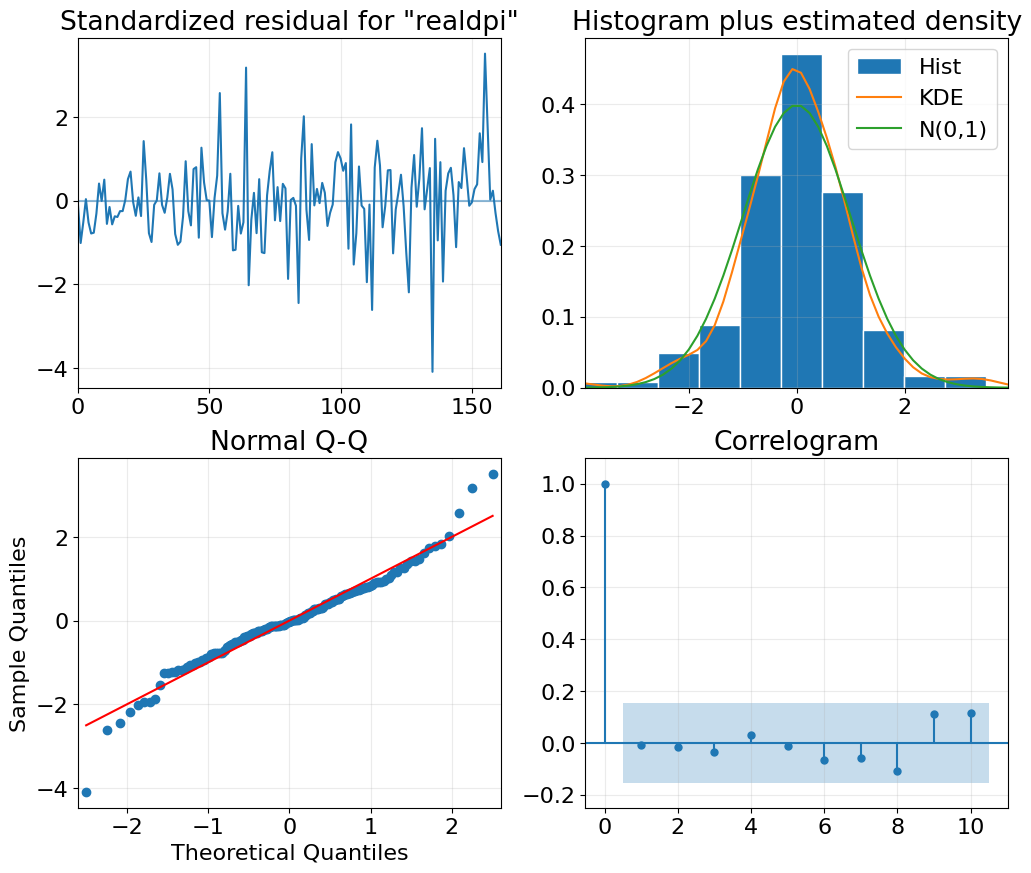

In [47]:
fig = model_var_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.25, 1.1])
plt.show(fig)

- The standardized residuals (top-left plot) seem to have no trend and   
  constant variance, which is in line with white noise.  
- The histogram (top-right plot) also closely resembles the shape of a normal   
  distribution.
- The Q-Q plot (bottom-left plot) shows fairly straight line that lies on $y = x$    
  although we can see some curvature at the extremities.   
- The correlogram (bottom-right plot) shows no significant coefficients except   
  at lag 5. However, this is likely due to chance, since there are no preceding  
  significant coefficients.

In summary we conclude that the residuals of `realdpi` are close to white noise.

Qualitative residual analysis of `realcons`

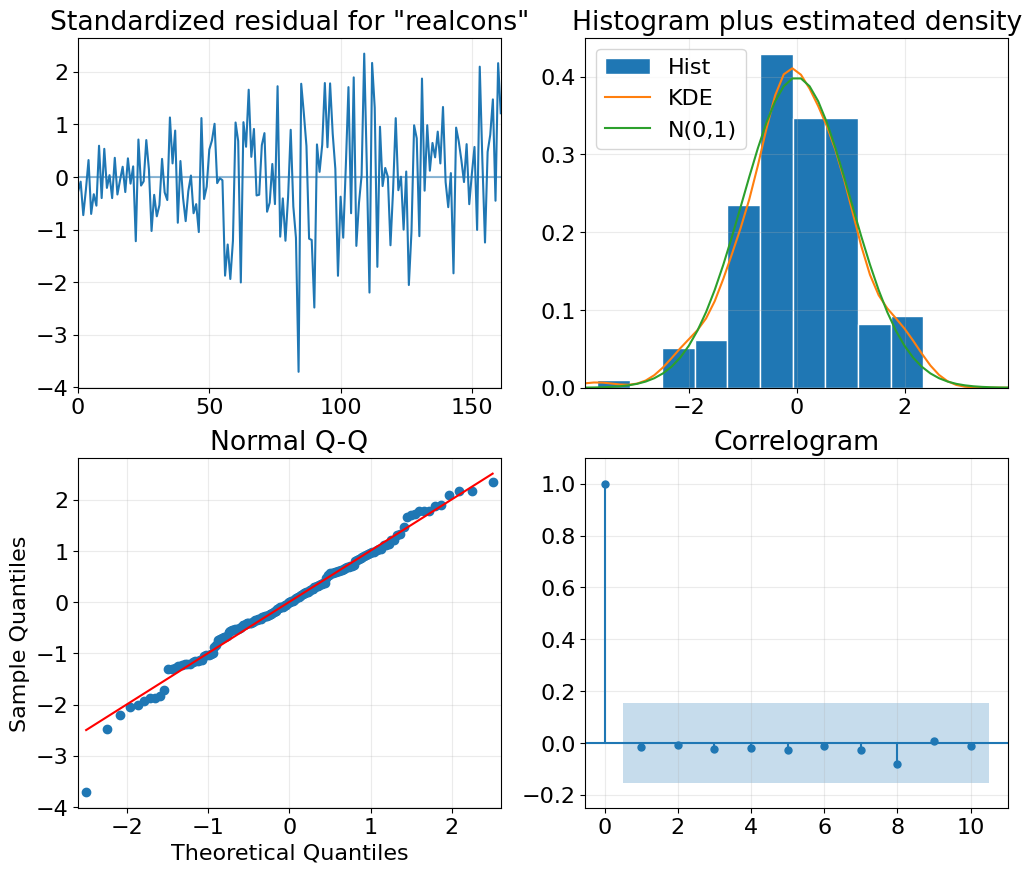

In [48]:
# Passing variable=1, we select the residual for the second time series which 
# is `realcons`
fig = model_var_best_fit.plot_diagnostics(figsize=(12, 10), variable=1)

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.25, 1.1])
plt.show(fig)


- The standardized residuals (top-left plot) seem to have no trend and   
  constant variance, which is in line with white noise.  
- The histogram (top-right plot) also closely resembles the shape of a normal   
  distribution.
- The Q-Q plot (bottom-left plot) shows fairly straight line that lies on $y = x$    
- The correlogram (bottom-right plot) shows no significant coefficients after   
  lag 0.   

In summary we conclude that the residuals of `realcons` are close to white noise.


Quantitative test for `realdpi` and `realcons`

In [49]:
realdpi_residuals = model_var_best_fit.resid["realdpi"]
realcons_residuals = model_var_best_fit.resid["realcons"]
ljung_box_test_realdpi = acorr_ljungbox(realdpi_residuals, np.arange(1, 11))
ljung_box_test_realcons = acorr_ljungbox(realcons_residuals, np.arange(1, 11))

sub_col = list(map(str, ljung_box_test_realdpi.columns)) + \
          list(map(str, ljung_box_test_realcons.columns))
sup_col = ["realdpi", "realdpi", "realcons", "realcons"]

midx = pd.MultiIndex.from_arrays([sup_col, sub_col])

ljung_box_test = pd.DataFrame(
  np.hstack([ljung_box_test_realdpi.to_numpy(), ljung_box_test_realcons.to_numpy()]),
  columns=midx)
ljung_box_test.style.set_table_styles([
  {'selector': 'th',
   'props': [
    ('text-align', 'center')
   ]}
])

The above test returns $p$-values that are all greater than 0.05. Again,   
we do not reject the null hypothesis, meaning that the residuals are not   
correlated and independent, just like white noise.

Next, we perform rolling forecast four steps into the future over the entire  
length of the test set. We also compare the model with the baseline model  
(last values)

In [50]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str, df_column_name: list, 
                      var_order: int = None) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "last":
    first_ts_pred_last_value = []
    second_ts_pred_last_value = []

    for i in range(train_len, total_len, window):
      first_ts_last_value = df[:i][df_column_name[0]].iloc[-1]
      second_ts_last_value = df[:i][df_column_name[1]].iloc[-1]
      
      first_ts_pred_last_value.extend(first_ts_last_value for _ in range(window))
      second_ts_pred_last_value.extend(second_ts_last_value for _ in range(window))

    return first_ts_pred_last_value, second_ts_pred_last_value

  elif method == "VAR":
    first_ts_pred_VAR = []
    second_ts_pred_VAR = []

    for i in range(train_len, total_len, window):
      model = VARMAX(df[:i][df_column_name], order=var_order)
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oov_pred_first_ts = predictions.predicted_mean.iloc[-window:][df_column_name[0]]   # oov: output of varmax
      oov_pred_second_ts = predictions.predicted_mean.iloc[-window:][df_column_name[1]]

      first_ts_pred_VAR.extend(oov_pred_first_ts)
      second_ts_pred_VAR.extend(oov_pred_second_ts)

    return first_ts_pred_VAR, second_ts_pred_VAR


In [51]:
idx_y = len(df_dpi_cons_diff_train) + 1   # idx_split = TRAIN_LEN in original time series
y1_0 = df_dpi_cons.iloc[idx_y - 1]["realdpi"]   # last element of data train but in original 
y2_0 = df_dpi_cons.iloc[idx_y - 1]["realcons"]

df_test_pred = df_dpi_cons[idx_y:].copy()

TRAIN_LEN = len(df_dpi_cons_diff_train)
HORIZON = len(df_dpi_cons_diff_test)
WINDOW = 4      # we want to forecast four time steps into the future (1 year)

# last value forecast uses original time series
# in the textbook the author set TRAIN_LEN for last_value is equal to TRAIN_LEN
# that is calculated from df_dpi_cons_diff_train. Because last_value model is
# inferred from original time series, TRAIN_LEN should be add 1 such that
# the the last value of training data in the original time series is align with
# the last value of training data in the first-differencing time series.
# You can check by the following code:
#   df_dpi_cons[:len(df_dpi_cons_diff_train)]   <-- you have to add the last index by one
#   df_dpi_cons_diff_train
# My suggestion is to add TRAIN_LEN by 1. But for the sake of simplicity and
# to align with the textbook discussion, I omitted to add this correction.
pred_last_value_realdpi, pred_last_value_realcons \
  = rolling_forecast(df_dpi_cons, TRAIN_LEN, HORIZON, WINDOW, 
                      "last", ["realdpi", "realcons"])

# VAR(p) model forecasting uses first-differencing time series
# In the textbook the author use endog = df_dpi_cons_diff.  In practice we do not 
# know all the dataset so it is better to set endog = df_dpi_cons_diff
pred_var_realdpi_diff, pred_var_realcons_diff \
  = rolling_forecast(df_dpi_cons_diff, TRAIN_LEN, HORIZON, WINDOW, 
                      "VAR", ["realdpi", "realcons"],
                       var_order=(best_p, 0))

df_test_pred["realdpi_pred_last"] = pred_last_value_realdpi
df_test_pred["realcons_pred_last"] = pred_last_value_realcons

# We transform back the result of VAR(p) to the original time eseries
df_test_pred["realdpi_pred_var"] = y1_0 + np.cumsum(pred_var_realdpi_diff)
df_test_pred["realcons_pred_var"] = y2_0 + np.cumsum(pred_var_realcons_diff)

c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [52]:
df_test_pred.head()

,year,realdpi,realcons,realdpi_pred_last,realcons_pred_last,realdpi_pred_var,realcons_pred_var
163,1999-10-01,7887.7,7389.2,7716.0,7199.9,7837.742590,7352.146106
164,2000-01-01,8053.4,7501.3,7716.0,7199.9,7913.597609,7427.362887
165,2000-04-01,8135.9,7571.8,7716.0,7199.9,7995.761699,7491.540835
166,2000-07-01,8222.3,7645.9,7716.0,7199.9,8063.596037,7549.962915
167,2000-10-01,8234.6,7713.5,8135.9,7571.8,8129.027986,7623.335227


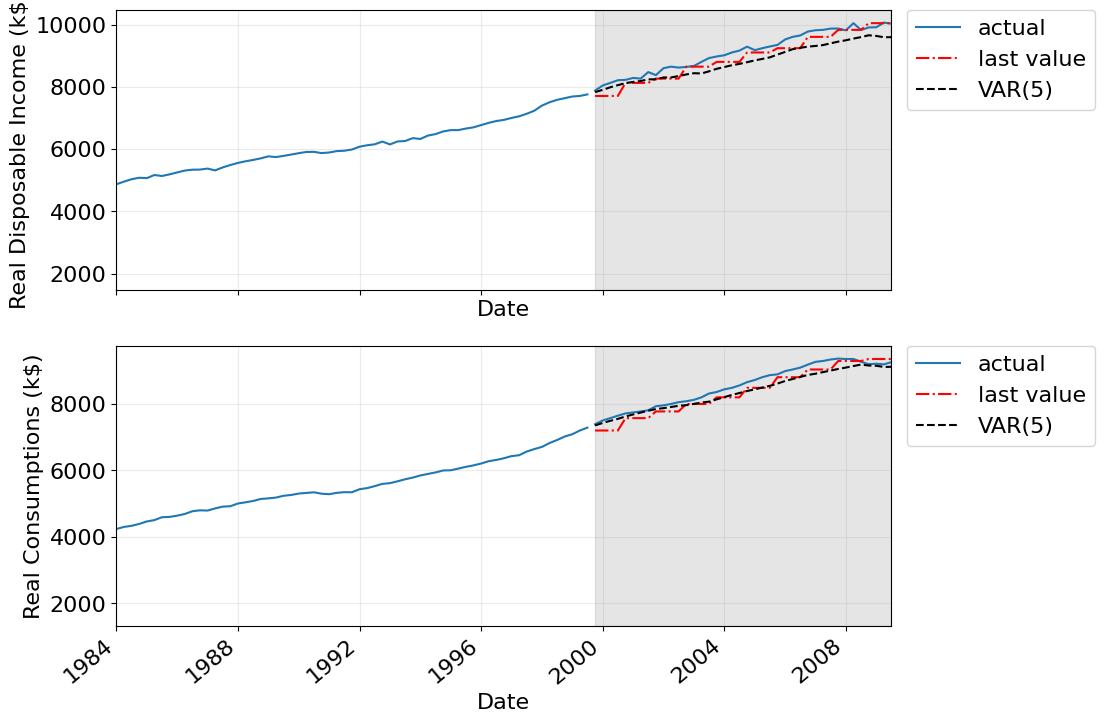

In [53]:
start_idx = 100  # for better visualization
xlim = [df_dpi_cons["year"].iloc[start_idx], df_dpi_cons["year"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

for ax, ts_name, title_name in zip(axes, ["realdpi", "realcons"], 
                                  ["Real Disposable Income (k$)", "Real Consumptions (k$)"]):
  ax.plot(df_dpi_cons["year"].iloc[:idx_y], df_dpi_cons[ts_name].iloc[:idx_y])
  ax.plot(df_dpi_cons["year"].iloc[idx_y:], df_dpi_cons[ts_name].iloc[idx_y:], color="tab:blue", label="actual")

  formatter = mdates.DateFormatter("%Y")
  # formatter = mdates.DateFormatter("%Y-%b-%d")
  locator = mdates.YearLocator(base=4)
  # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 4))
  # locator = mdates.DayLocator()
  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  # ax.set_ylim([-0.5, 17])
  ax.set_xlim(xlim)
  ax.grid("on")
  ax.set_xlabel("Date")
  ax.set_ylabel(title_name)

  # -- prediction
  ax.plot(df_test_pred["year"], df_test_pred[f"{ts_name}_pred_last"], "r-.", label="last value")
  ax.plot(df_test_pred["year"], df_test_pred[f"{ts_name}_pred_var"], "k--", label=f"VAR({best_p})")

  # add forecast area
  ax.axvspan(df_dpi_cons['year'].iloc[idx_y], df_dpi_cons['year'].iloc[-1], 
                  color="#808080", alpha=0.2)

  # -- add legend in the second row
  ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)



for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')


plt.show(fig)

Evaluate the models

In [54]:
realdpi_mape_last = mean_absolute_percentage_error(df_test_pred["realdpi"], df_test_pred["realdpi_pred_last"]) * 100
realdpi_mape_var  = mean_absolute_percentage_error(df_test_pred["realdpi"], df_test_pred["realdpi_pred_var"]) * 100

print(f"realdpi")
print(f"  MAPE last: {realdpi_mape_last:.3f}%")
print(f"   MAPE VAR: {realdpi_mape_var:.3f}%")

realcons_mape_last = mean_absolute_percentage_error(df_test_pred["realcons"], df_test_pred["realcons_pred_last"]) * 100
realcons_mape_var  = mean_absolute_percentage_error(df_test_pred["realcons"], df_test_pred["realcons_pred_var"]) * 100

print(f"realcons")
print(f"  MAPE last: {realcons_mape_last:.3f}%")
print(f"   MAPE VAR: {realcons_mape_var:.3f}%")



realdpi
  MAPE last: 2.263%
   MAPE VAR: 3.458%
realcons
  MAPE last: 2.459%
   MAPE VAR: 2.067%


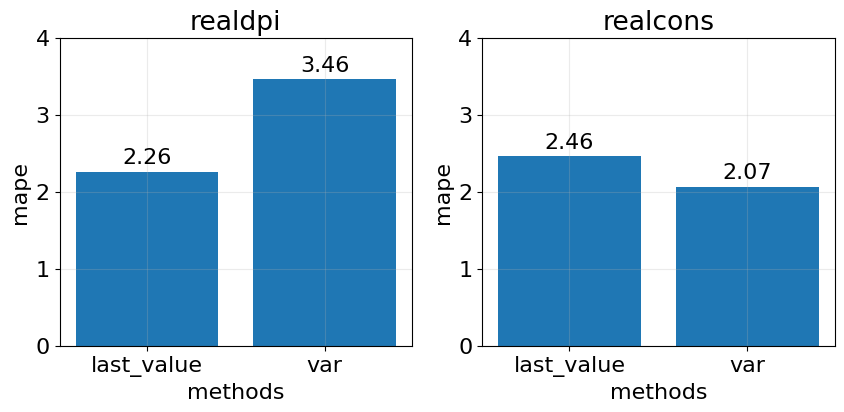

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# -- realdpi
x_array = ["last_value", "var"]
y_array = [realdpi_mape_last, realdpi_mape_var]

axes[0].bar(x_array, y_array)
axes[0].grid("on")
axes[0].set_xlabel("methods")
axes[0].set_ylabel("mape")
axes[0].set_ylim([0, 4])
axes[0].set_title("realdpi")

for idx, val in enumerate(y_array):
  axes[0].text(x=idx, y=val+0.1, s=f"{val:.2f}", ha="center")

# -- realcons
x_array = ["last_value", "var"]
y_array = [realcons_mape_last, realcons_mape_var]

axes[1].bar(x_array, y_array)
axes[1].grid("on")
axes[1].set_xlabel("methods")
axes[1].set_ylabel("mape")
axes[1].set_ylim([0, 4])
axes[1].set_title("realcons")

for idx, val in enumerate(y_array):
  axes[1].text(x=idx, y=val+0.1, s=f"{val:.2f}", ha="center")

plt.show(fig)



In figure above, you can see that the $\text{VAR}(3)$ model performs worse than  
the baseline in the case of `realdpi` but better than the baseline for `realcons`.   
This is an ambiguous situation. There is no clear result, since the model does not  
outperform the baseline in both situations.  

We can hypothesize that in the case of `realdpi`, `realcons` is not predictive enough  
to make more accurate forecasts than the baseline, even though the Granger causality  
test passed. Therefore, we should resort to using a variation of the SARIMAX model  
to predict `realdpi`. Thus, we would conclude that the $\text{VAR}(3)$ model is  
not sufficient to accurately forecast `realdpi` and `realcons`. We would suggest  
using two separate models, which could include `realdpi` and `realcons` as exogenous  
variables, while also potentially including moving average terms.

## 10.4 Next steps

Our previous methods are great for smaller datasets with low dimensionality.   
However, when datasets start getting large, starting at 10,000 data points or  
more, and they have many features (high dimensionality), deep learning can be   
a great tool for obtaining accurate forecasts and leveraging all the available data.

For the upcoming weeks, we will explore a capstone project to consolidate our  
knowledge of statistical methods. Then, we'll start a new section and apply   
deep learning forecasting models on large datasets.